In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd/content/drive/MyDrive/ViT

/content/drive/.shortcut-targets-by-id/1s7sXpN-JpiTwAiQwZWGPTza7tKIQLzAa/ViT


In [ ]:
import torch
from torch import nn
import model
import patchdata
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import cv2

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vit = model.VisionTransformer(patch_vec_size=48, num_patches=64,
                                  latent_vec_dim=128, num_heads=8, mlp_hidden_dim=64,
                                  drop_rate=0., num_layers=12, num_classes=10).to(device)
vit.load_state_dict(torch.load('./model.pth'))                                  

<All keys matched successfully>

## 1. Linear Projection Weights

In [ ]:
# 전체에 대해서 min-max scaling 하고

def minmax(x):
    m = torch.min(x)
    M = torch.max(x)
    return (M-x)/(M-m)

In [ ]:
# linear_embedding matrix = weight

linear_embedding = vit.patchembedding.linear_proj.weight

In [ ]:
# patch size = 4
# image channel = 3
# 1x(P^2C) -> linear_proj (CP^2)xD -> 1xD 저차원 매핑
# --> (CP^2)xD를 3차원 매핑으로 만들어주기 위해서 CxPxP로 앞부분을 펴줌

# linear_embedding: (CP^2)xD
rgb_embedding_filters = linear_embedding.detach().cpu().view(3,4,4,-1).permute(3,0,1,2) # 학습 할 거 아니라서 detach/ 3x4x4 짜리가 D개 / D가 개수니깐 위치를 앞으로 빼가지고 표현

In [ ]:
rgb_embedding_filters.size()

torch.Size([128, 3, 4, 4])

In [ ]:
rgb_embedding_filters = minmax(rgb_embedding_filters) # min-max scaling이용해서 모든 값을 0~1로 만들어줬음.

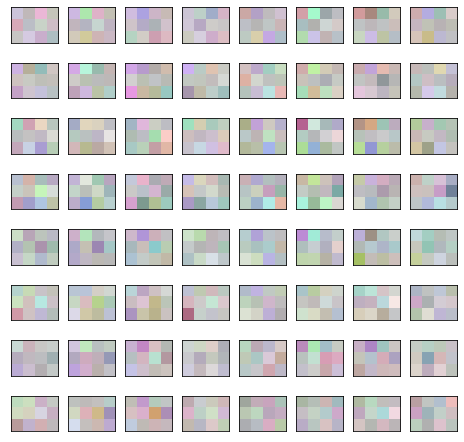

In [ ]:
# 64 rgb embedding filters out of 128
fig = plt.figure(figsize=(8, 8))
for i in range(1,65):
    rgb = rgb_embedding_filters[i-1].numpy() # 실제값을 rgb fileter의 0번째부터
    ax = fig.add_subplot(8, 8, i) # 8 x 8짜리 plot만들어서 
    ax.axes.get_xaxis().set_visible(False) # x축 눈금 삭제
    ax.axes.get_yaxis().set_visible(False) # y축 눈금 삭제
    ax.imshow(rgb)

## 2. Positional Embedding

In [ ]:
pos_embedding = vit.patchembedding.pos_embedding # [1, 65(64+class token), 128]

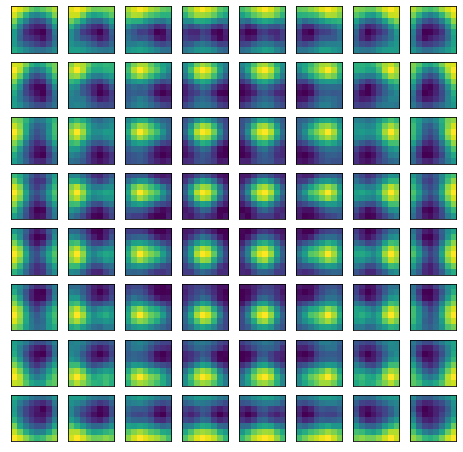

In [ ]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
fig = plt.figure(figsize=(8, 8))
for i in range(1, pos_embedding.shape[1]): # idx 0은 class token이기 때문에 idx 1부터 plotting

    # consine_similarity는 1 vs N 계산이 한 번에 됨. 따라서 for문은 하나만 사용
    sim = F.cosine_similarity(pos_embedding[0, i:i+1], pos_embedding[0, 1:], dim=1)
    sim = sim.reshape((8, 8)).detach().cpu().numpy() # 8 x 8로 만들고
    ax = fig.add_subplot(8, 8, i) # 8 x 8  subplot 
    ax.axes.get_xaxis().set_visible(False) # 눈금 삭제
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

## 3. Attention 

In [ ]:
def imshow(img):
    plt.figure(figsize=(4,4))   
    plt.imshow(img.permute(1,2,0).numpy()) # h,w,c
    plt.axis('off')
    plt.show()
    plt.close()
    return img

In [ ]:
# Patch data가 잘 잘렸는 지 확인할 때는 normalize 안하고 했는데
# 여기서는 Normalization 한 데이터를 가지고 학습을 하기 때문에 Normalization 한 놈을 그대로 사용함
# 이미지를 살리고 싶으면 역으로 Normalization을 해줘야 함.

# Inverse Normalization
def inv_normal(img):
    img  = img.reshape(64, -1, 4, 4)

    # cifar10 mean, std
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)
    print(img.size())
    for i in range(3):
        img[:,i,:,:] = torch.abs(img[:,i,:,:]*std[i] + mean[i])
    return img   

In [ ]:
# 데이터 하나 불러오기
d = patchdata.Flattened2Dpatches(dataname='cifar10', img_size=32, patch_size=4,
                                     batch_size=16)
_, _, testloader = d.patchdata()
image_patch, label = iter(testloader).next()
image_patch = image_patch[12:13] # 임의의 패치 하나 불러오기 12번째

Files already downloaded and verified
Files already downloaded and verified


torch.Size([64, 3, 4, 4])


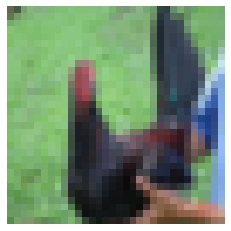

In [ ]:
sample = inv_normal(image_patch)

# 64 x 3 x 4 x 4 짜리 패치를 통해서 padding = 0으로 설정을 해놓고 plotting을 때리면 사이즈가 torch.Size([3, 32, 32]) 이렇게 됨.
original_img = imshow(torchvision.utils.make_grid(sample, nrow=8, padding=0)) # 잘려있는 패치들을 한 번에 출력해주는 함수 / padding = 0 이면 패치 간 공백없이 출력하겠다는 의미

In [ ]:
print(original_img.size())   # make_grid 함수를 통해서 한 번에 원본 이미지 구하기 가능

torch.Size([3, 32, 32])


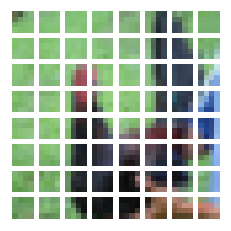

In [ ]:
# 이게 이미지 한 장, subplot들을 모아서 이미지 한 장으로 출력해줌.
_ = imshow(torchvision.utils.make_grid(sample, nrow=8, padding=1, pad_value=1)) # pad_value =1 흰색 / 0 검은색

In [ ]:
vit.eval() # dropout 없어야됨.
output, attention = vit(image_patch.to(device)) # 결과를 보고 싶어서 attention까지 받음

In [ ]:
# attention이 list로 다 모아놓은 거라서 list를 tensor로 바꿈

attention = torch.stack(attention).squeeze(1) # [12, 1, 8, 65, 65] -> [12, 8, 65, 65]  :: 65 x 65 짜리가 각 층(Head)에 8개씩 있고, 그 층(layer 수)이 12개이다.

In [ ]:
# 얘를 동일한 scale로 고려해주기 위해서 한 번에 minmax 계산하고 

attention_heads = attention.view(-1,65,65)
attention_heads = minmax(attention_heads)

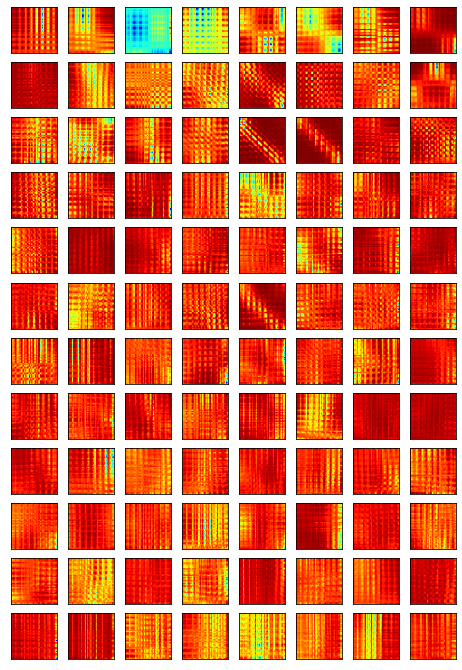

In [ ]:
fig = plt.figure(figsize=(8, 12)) # 8 x 12 에 대한 plotting

for i in range(1,97):
    result = attention_heads[i-1].detach().cpu().numpy()
    res_tensor = torch.Tensor(result)#.permute(1,2,0)
    ax = fig.add_subplot(12, 8, i)
    ax.axes.get_xaxis().set_visible(False) # x축 눈금 삭제
    ax.axes.get_yaxis().set_visible(False) # y축 눈금 삭제
    ax.imshow(res_tensor, vmin=np.min(result), vmax=np.max(result), cmap='jet')
    

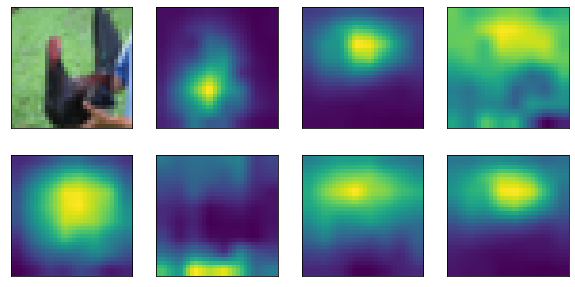

In [ ]:
# Attention을 임의로 Visulaizatin
# 임의의 Attention을 잡아서 plotting


fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(2, 4, 1)
ax.axes.get_xaxis().set_visible(False) # x축 눈금 삭제
ax.axes.get_yaxis().set_visible(False) # y축 눈금 삭제
ax.imshow(original_img.permute(1,2,0))


for i in range(7):  # visualize the 4th rows of attention matrices in the 0-7th heads
    attn_heatmap = attention[0, i, 4, 1:].reshape((8, 8)).detach().cpu().numpy() # 가장 앞단에 있는 layer에다가 head 7개 뿌림, 
    attn_heatmap = cv2.resize(attn_heatmap,(32,32))
    ax = fig.add_subplot(2, 4, i+2)
    ax.axes.get_xaxis().set_visible(False) # x축 눈금 삭제
    ax.axes.get_yaxis().set_visible(False) # y축 눈금 삭제
    ax.imshow(attn_heatmap)

## Parameter name

In [ ]:
# 학습 가능한 목록들이 뜸
for name, param in vit.named_parameters():
    print(name, param.size())

patchembedding.cls_token torch.Size([1, 128])
patchembedding.pos_embedding torch.Size([1, 65, 128])
patchembedding.linear_proj.weight torch.Size([128, 48])
patchembedding.linear_proj.bias torch.Size([128])
transformer.0.ln1.weight torch.Size([128])
transformer.0.ln1.bias torch.Size([128])
transformer.0.ln2.weight torch.Size([128])
transformer.0.ln2.bias torch.Size([128])
transformer.0.msa.query.weight torch.Size([128, 128])
transformer.0.msa.query.bias torch.Size([128])
transformer.0.msa.key.weight torch.Size([128, 128])
transformer.0.msa.key.bias torch.Size([128])
transformer.0.msa.value.weight torch.Size([128, 128])
transformer.0.msa.value.bias torch.Size([128])
transformer.0.mlp.0.weight torch.Size([64, 128])
transformer.0.mlp.0.bias torch.Size([64])
transformer.0.mlp.3.weight torch.Size([128, 64])
transformer.0.mlp.3.bias torch.Size([128])
transformer.1.ln1.weight torch.Size([128])
transformer.1.ln1.bias torch.Size([128])
transformer.1.ln2.weight torch.Size([128])
transformer.1.ln2